In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [18]:
# Importar mapa de la CDMX
cdmx = gpd.read_file('./analisis_reportes_agua/src/poligonos_cdmx_datos_modificados/poligonos_cdmx.shp')

# Importar recopilado de datos historico
historico = pd.read_csv('./analisis_reportes_agua/src/csv/historico_completo.csv')

¿Cuáles son los principales problemas de agua en la ciudad de Mexico?

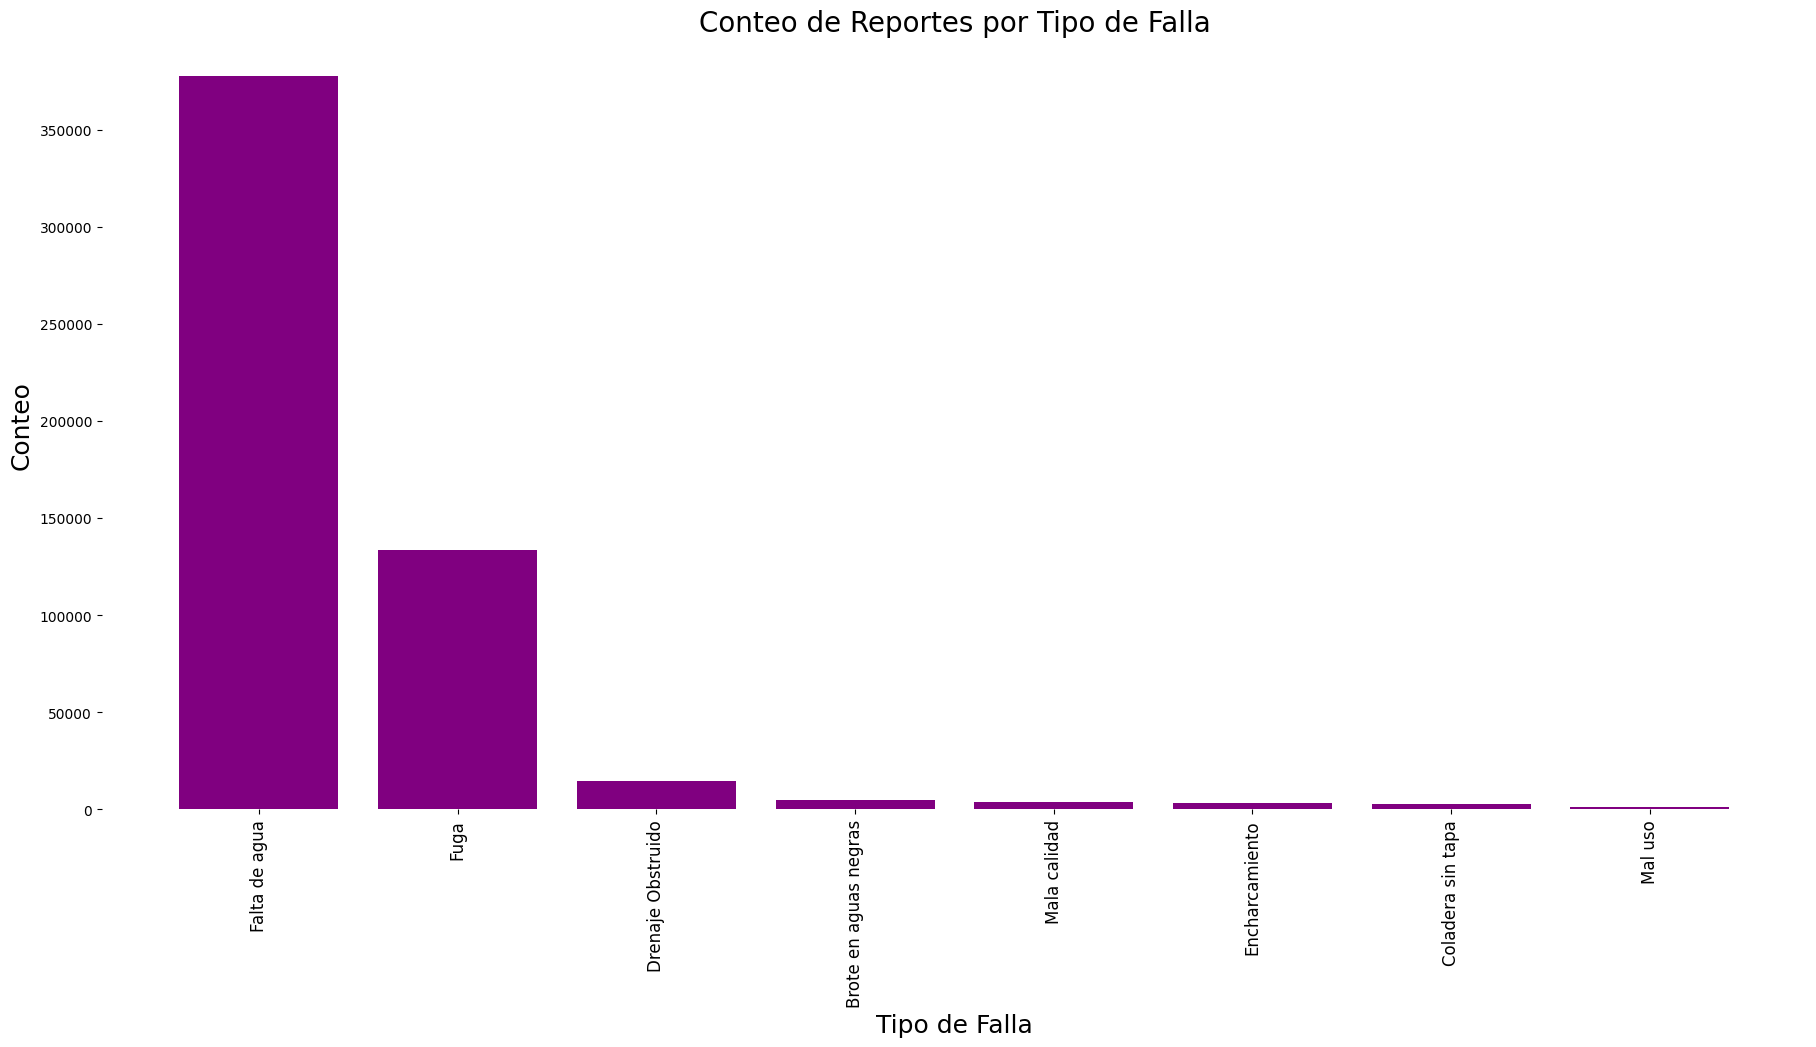

tipo_falla  conteo
0          Falta de agua  377520
1                   Fuga  133462
2      Drenaje Obstruido   14455
3  Brote en aguas negras    4686
4           Mala calidad    3874
5         Encharcamiento    3077
6      Coladera sin tapa    3041
7                Mal uso    1263

In [62]:
# Contar la frecuencia de cada tipo de falla
conteo_reportes = historico['tipo_de_falla'].value_counts()

# Filtrar para solo mostrar tipos de falla con más de 1,000 reportes
conteo_reportes = conteo_reportes[conteo_reportes > 1000]

# Convertir Series a DataFrame y resetear el índice
conteo_reportes = pd.DataFrame(conteo_reportes).reset_index()

# Renombrar las columnas
conteo_reportes.columns = ['tipo_falla', 'conteo']

# Crear un gráfico de barras
plt.figure(figsize=(22, 10))
bars = plt.bar(conteo_reportes['tipo_falla'], conteo_reportes['conteo'], color='purple')

plt.xlabel('Tipo de Falla', fontsize=18)  # Ajustar el tamaño de la fuente de xlabel
plt.ylabel('Conteo', fontsize=18)         # Ajustar el tamaño de la fuente de ylabel
plt.title('Conteo de Reportes por Tipo de Falla', fontsize=20)
# Quitar el marco negro
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.xticks(rotation=90, fontsize=12)  # Rotar las etiquetas del eje x si son largas
plt.show()

conteo_reportes

¿Cuál es la distribución, por alcaldia de los tres principales problemas de agua de la Ciudad de México ?

In [56]:
# Función que grafica mapa de la CDMX con gradiente en función del tipo de falla, coordenadas de los reportes e histograma por alcaldía 
def graficos(historico, columna, falla, colorGradiente, colorPuntos, colorHistograma):

   #### Gráfico de Gradiente ####

   # Filtrar datos por tipo de falla
   fallaFiltro = historico[historico['tipo_de_falla'] == falla]

   # Contar las fallas por alcaldía
   fallaConteo  = fallaFiltro['alcaldia'].value_counts().reset_index()

   # Asignar los nombres de columna
   fallaConteo.columns = ['alcaldia','conteo']

   fallaConteoOrdenado = fallaConteo

   # Los ordena en forma descendente por 'alcaldia'
   fallaConteo = fallaConteo.sort_values(by=columna, ascending=True)

   # Fusionar cdmx con conteo_alcaldias
   cdmxReportes = cdmx
   cdmxReportes = cdmx.merge(fallaConteo, left_on='NOMGEO', right_on=columna, how='left')

   # Grafica el mapa con un gradiente de color en función del número de reportes
   fig, ax = plt.subplots(1, 1, figsize=(10, 10))
   cdmxReportes.plot(ax=ax, column='conteo', cmap=colorGradiente, linewidth=0.8, edgecolor='black', legend=True)
   ax.set_title('Gradiente de Reportes por ' + falla, fontsize=18)
   ax.set_xlabel('Longitud', fontsize=14)
   ax.set_ylabel('Latitud', fontsize=14)
      
   # Quitar el marco negro
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['bottom'].set_visible(False)

   # Inserta la barra de gradiente
   leg = ax.get_legend()

   # Inserta el nombre de la alcaldía
   for idx, row in cdmxReportes.iterrows():
      plt.annotate(row['NOMGEO'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),horizontalalignment='center', fontsize=5, color='black')

   # Guardar como imagen PNG
   plt.savefig('./analisis_reportes_agua/src/images/mapa_degradado_' + falla + '.svg', dpi=1000 , transparent=True)

   plt.show()

   #### Gráfica de coordenadas de las fallas #####

   # Convertir el DataFrame en un GeoDataFrame
   geometry = [Point(xy) for xy in zip(fallaFiltro['longitud'], fallaFiltro['latitud'])]
   gdf_puntos = gpd.GeoDataFrame(fallaFiltro, geometry=geometry)

   # Asegurar que ambos GeoDataFrames estén en la misma proyección
   gdf_puntos.crs = cdmx.crs

   # Crear una figura
   fig, ax = plt.subplots(1, 1, figsize=(10, 10))

   # Graficar el shapefile
   cdmx.plot(ax=ax, color='white', edgecolor='black')

   # Graficar los puntos
   gdf_puntos.plot(ax=ax, color=colorPuntos, markersize=0.1, marker='*')

   # Añadir título y etiquetas de ejes
   ax.set_title('Ubicación de Reportes por ' + falla, fontsize=18)
   ax.set_xlabel('Longitud', fontsize=14)
   ax.set_ylabel('Latitud', fontsize=14)

   # Quitar el marco negro
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(False)
   ax.spines['bottom'].set_visible(False)

   # Guardar como imagen PNG
   plt.savefig('./analisis_reportes_agua/src/images/mapa_puntos_' + falla, dpi=500, transparent=True)

   # Mostrar el gráfico
   plt.show()


   #### Gráfico de histograma ####

   # Guardar el gráfico como imagen
   plt.figure(figsize=(20, 10))
   plt.bar(fallaConteoOrdenado['alcaldia'], fallaConteoOrdenado['conteo'], color=colorHistograma)
   plt.xlabel('Alcaldía')
   plt.ylabel('Conteo')
   plt.title('Distribución por Alcaldía de Reportes por ' + falla)
   plt.xticks(rotation=90)
   plt.tight_layout() 
   # Añadir un grid punteado
   #plt.grid(True, which='both', linestyle=':', linewidth=0.5)

   # Quitar el marco negro
   plt.gca().spines['top'].set_visible(False)
   plt.gca().spines['right'].set_visible(False)
   plt.gca().spines['left'].set_visible(False)
   plt.gca().spines['bottom'].set_visible(False)

   # Guardar como imagen PNG
   plt.savefig('./analisis_reportes_agua/src/images/mapa_histograma_' + falla + '.svg', dpi=1000, transparent=True)

   # Mostrar el gráfico
   plt.show()

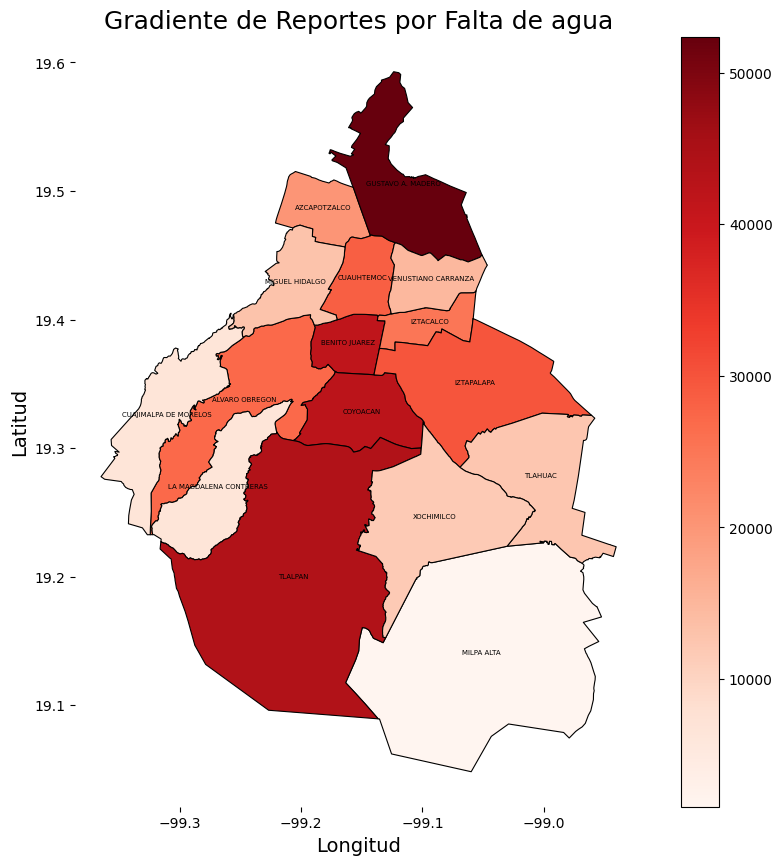

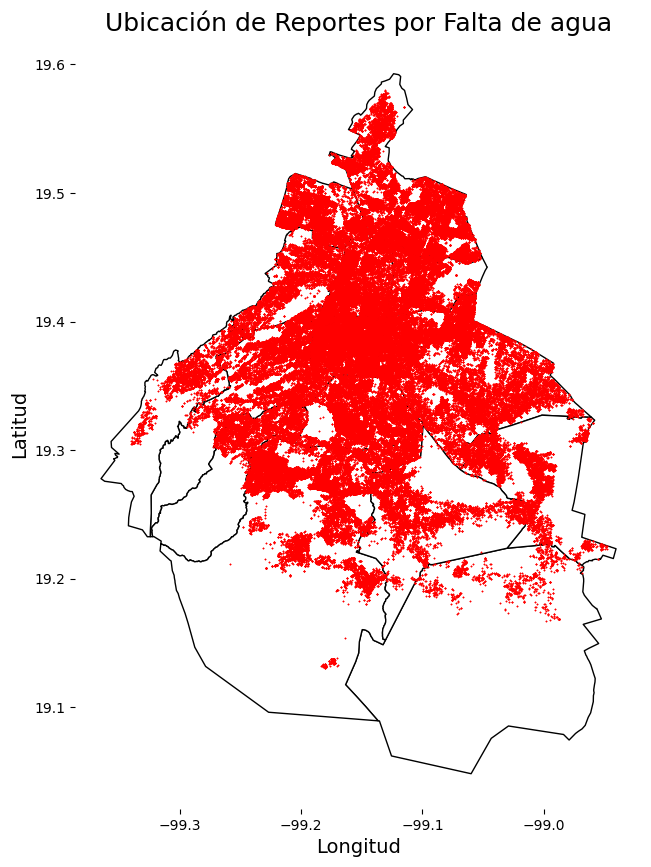

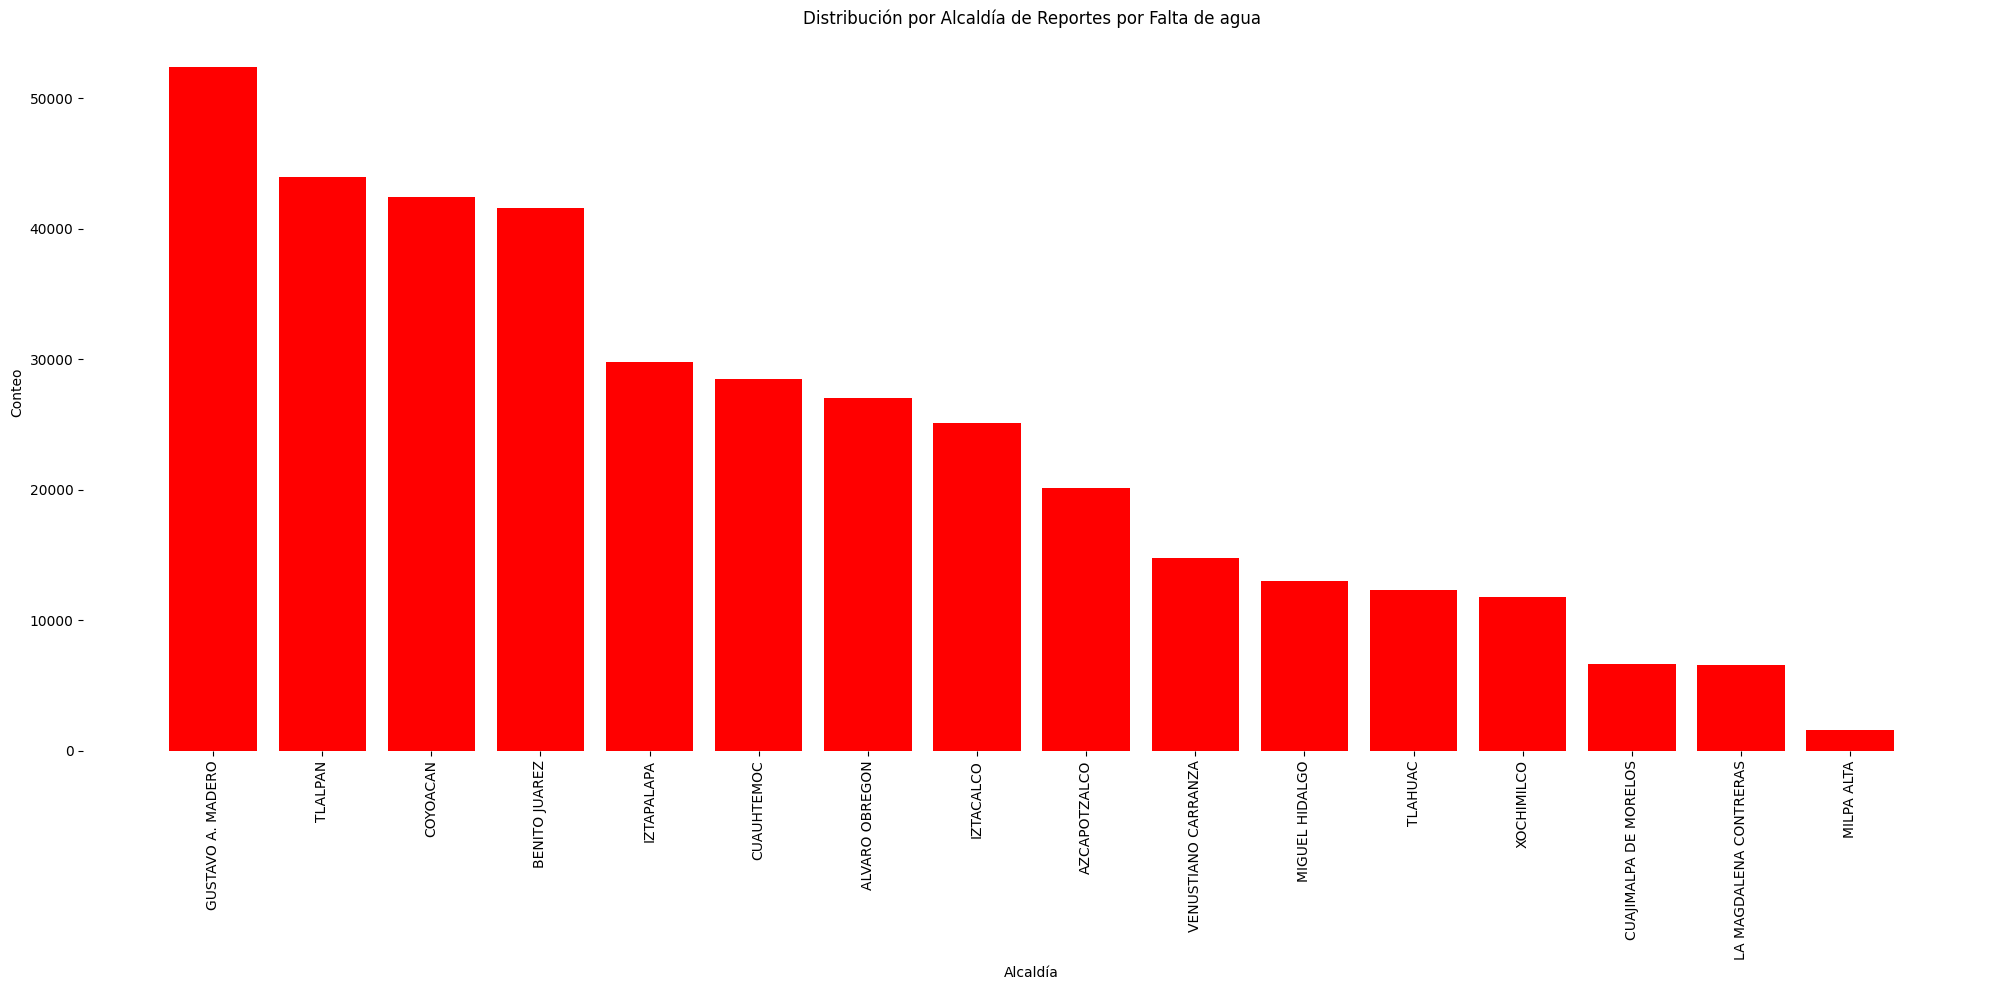

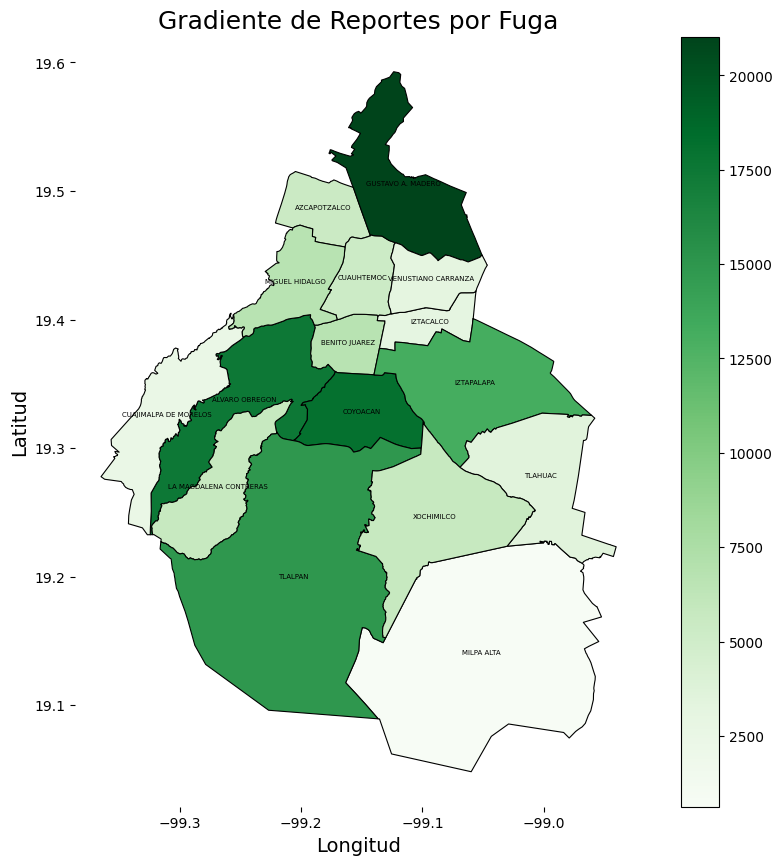

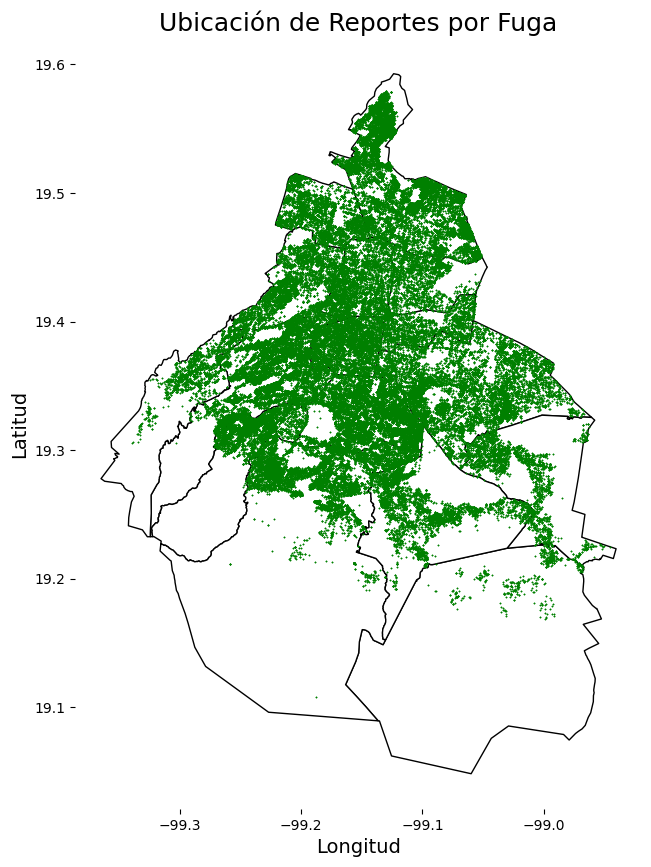

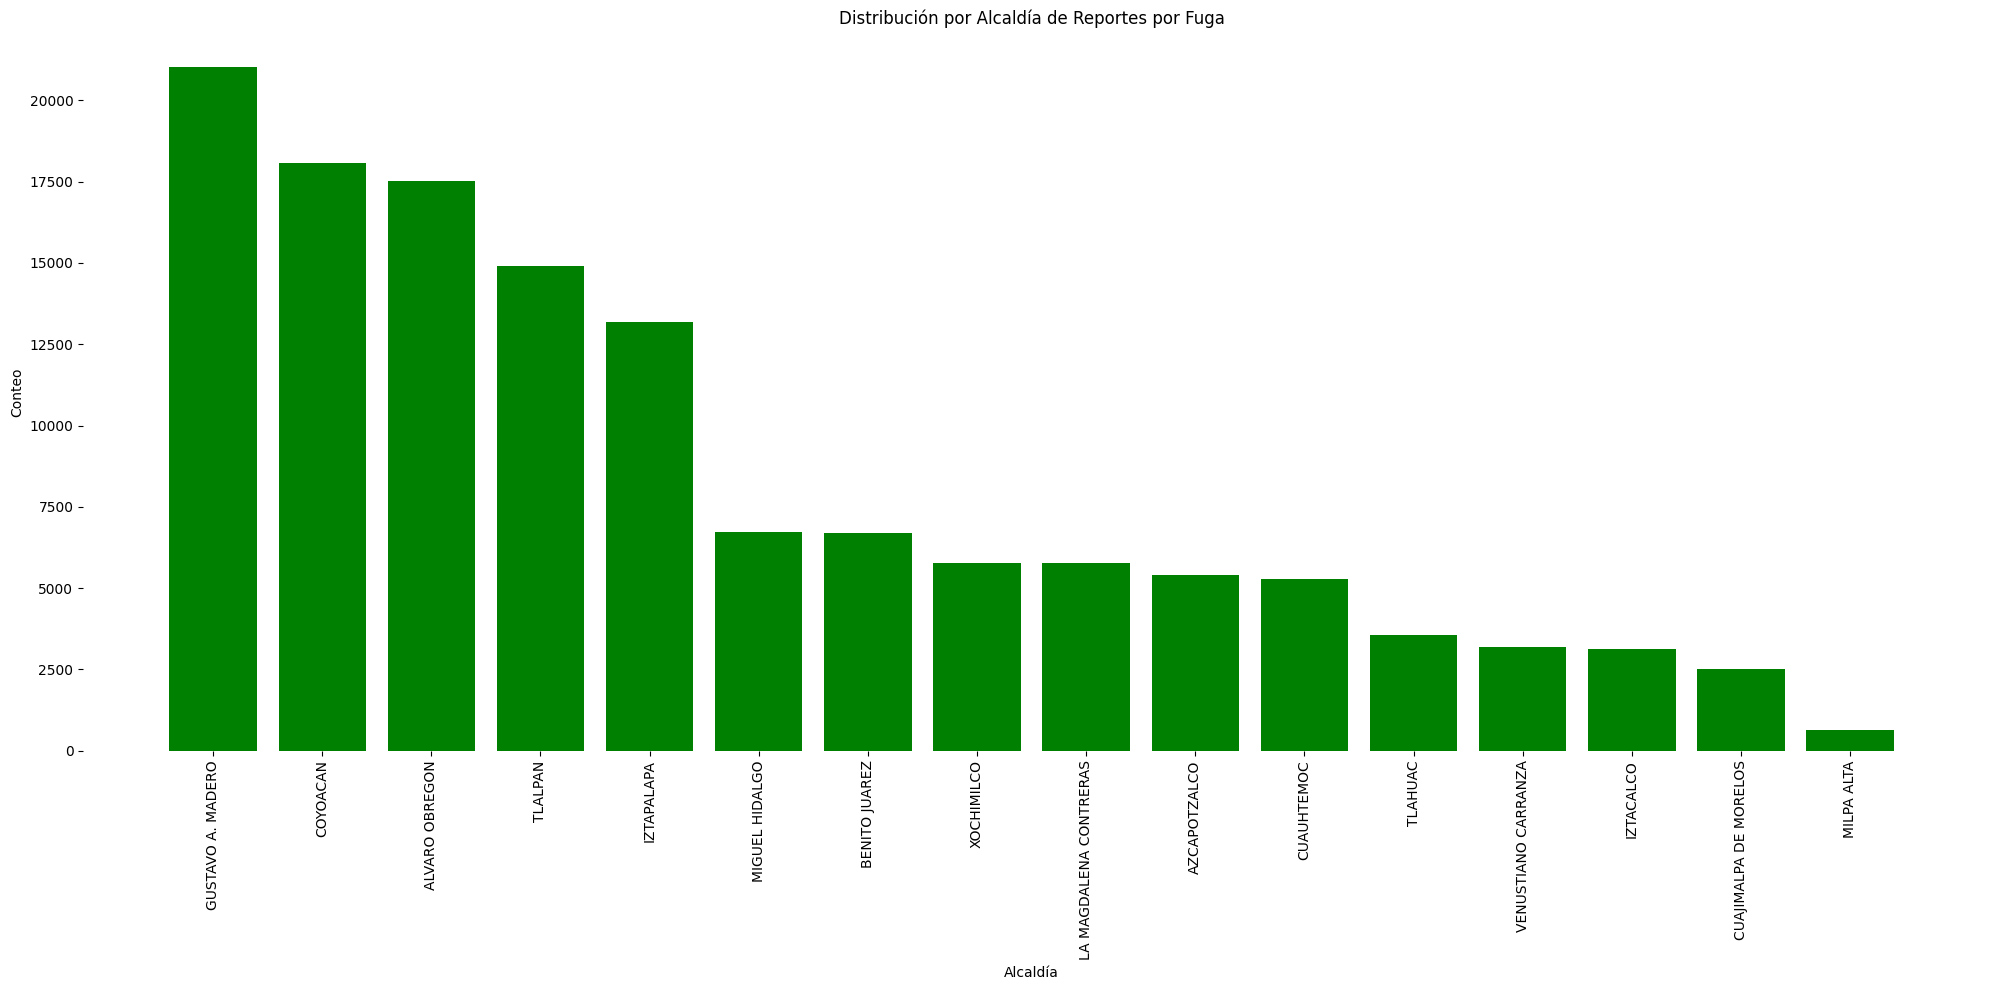

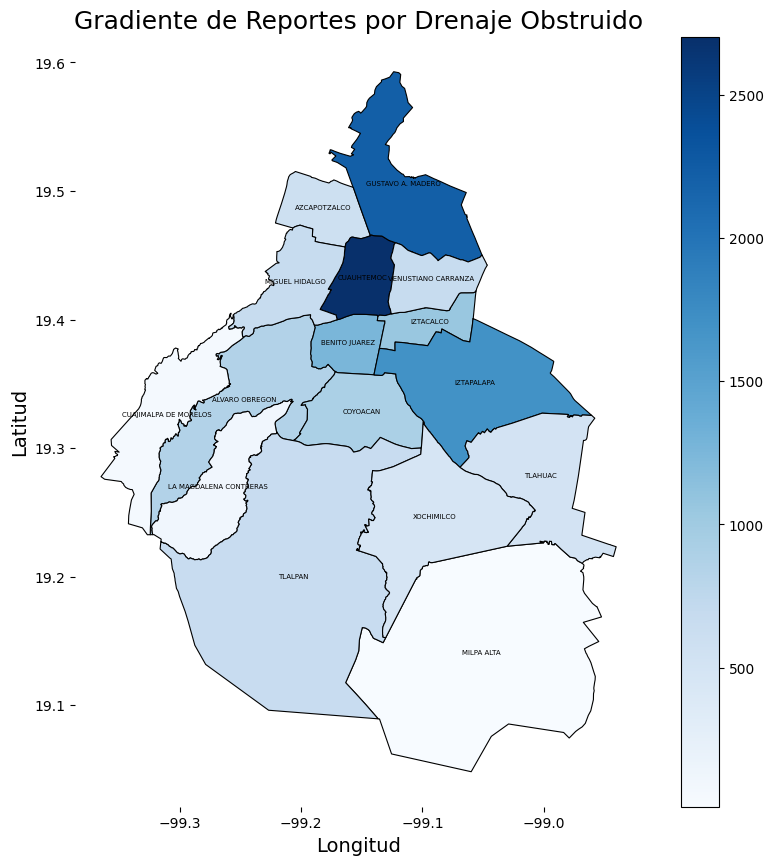

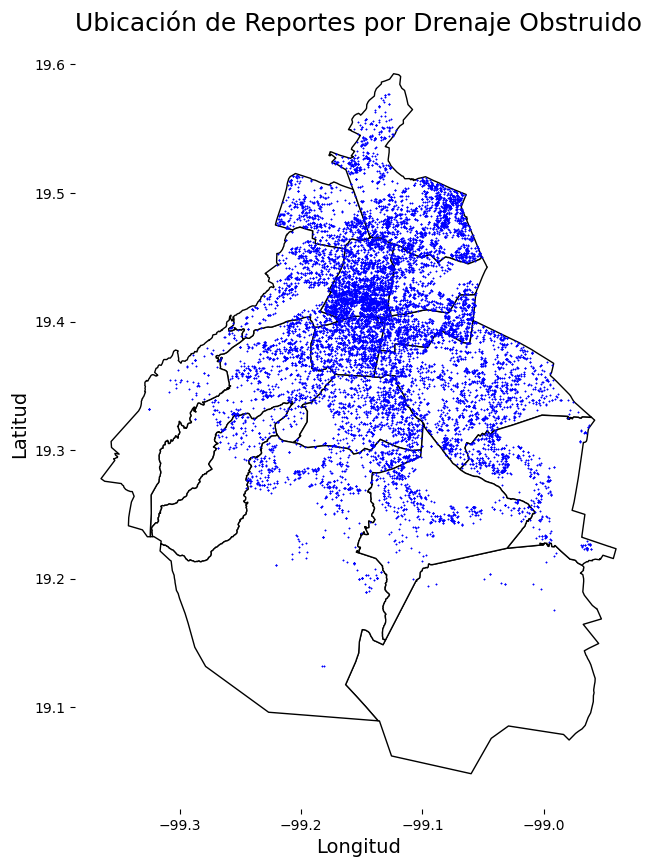

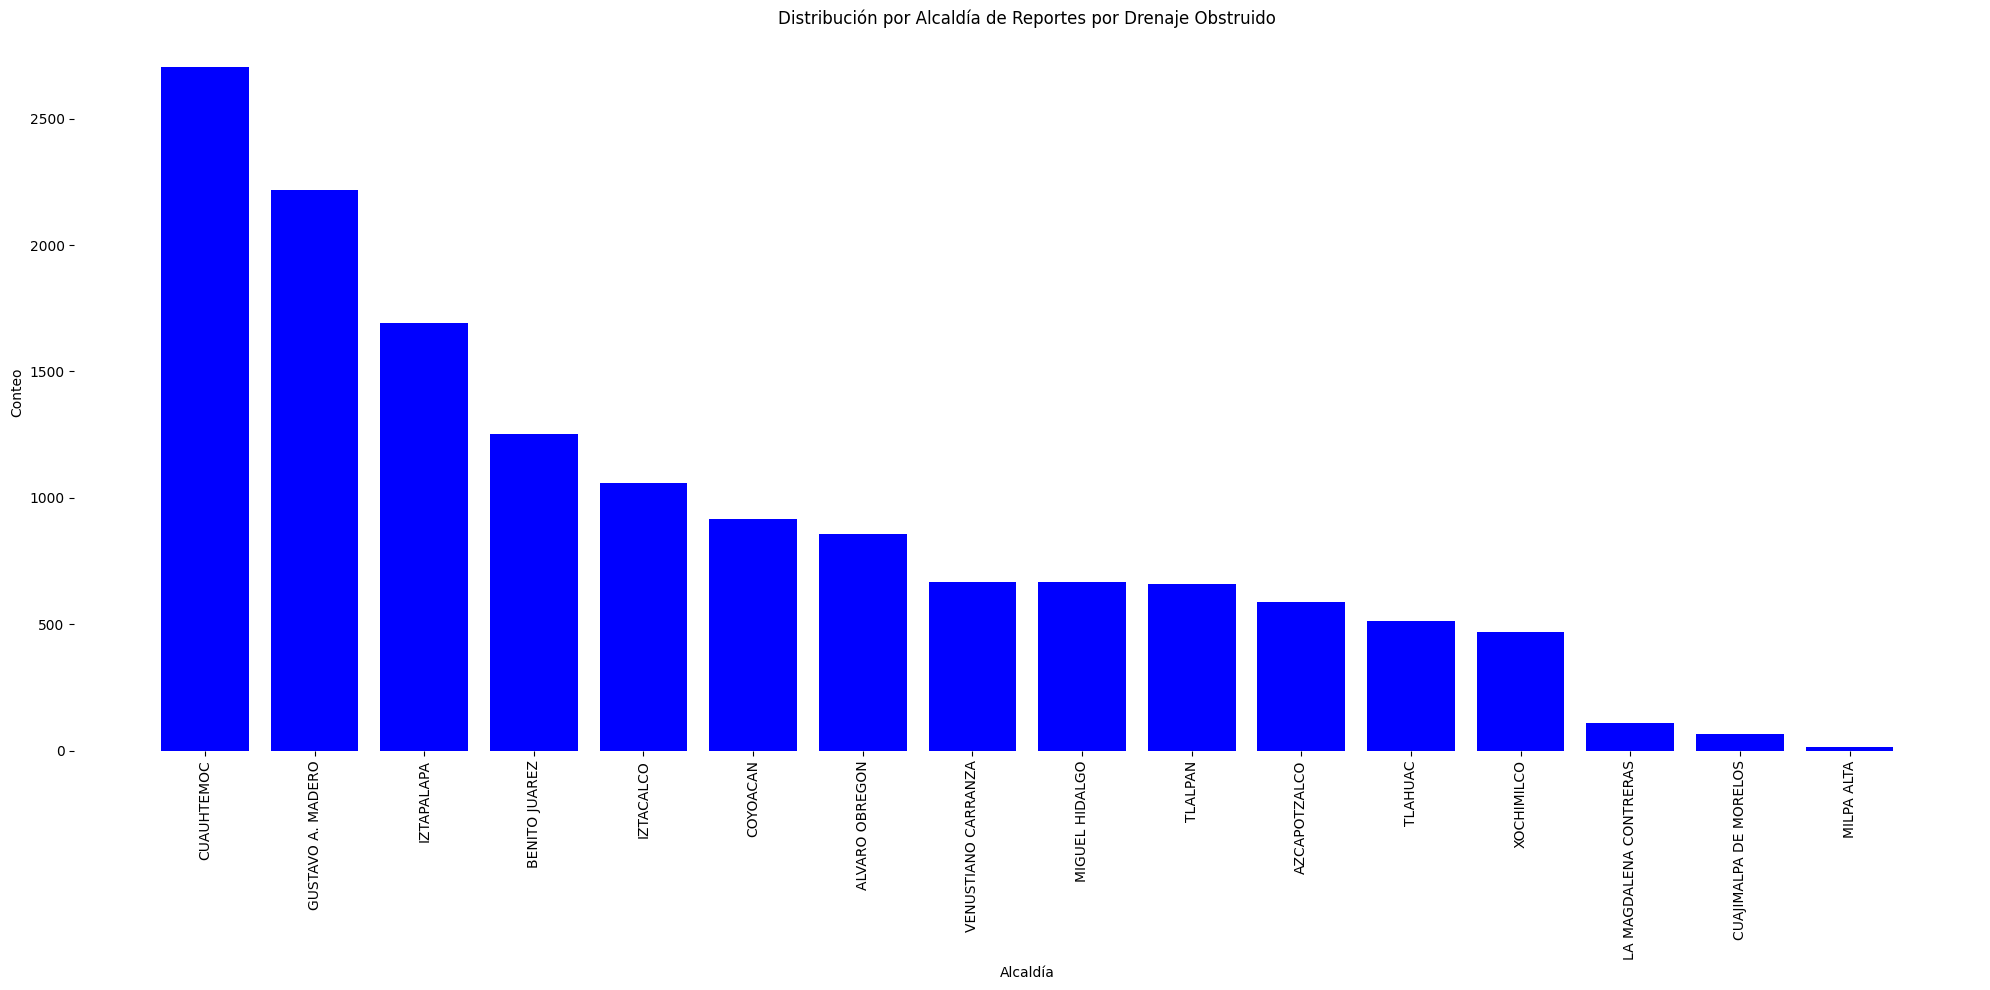

In [57]:
graficos(historico=historico, columna='alcaldia', falla='Falta de agua', colorGradiente='Reds', colorPuntos='red', colorHistograma='red')
graficos(historico=historico, columna='alcaldia', falla='Fuga', colorGradiente='Greens', colorPuntos='green', colorHistograma='green')
graficos(historico=historico, columna='alcaldia', falla='Drenaje Obstruido', colorGradiente='Blues', colorPuntos='blue', colorHistograma='blue')

¿Cuál es el promedio de los reportes de falta de agua en la Ciudad de México durante los últimos años?

Por día, por mes y por año

In [22]:
# Promedio de reportes de falta de agua por día

# Conteo de fallas por mes desde 2018-01 -- 2024-02

def promedioDistribucion(periodo):



    # Filtrar datos por tipo de falla
    fallaFiltro = historico[historico['tipo_de_falla'] == 'Falta de agua'].copy()

    # Convertir la columna 'fecha' a tipo datetime
    fallaFiltro['fecha'] = pd.to_datetime(fallaFiltro['fecha'])

    if periodo == 'D':
        titulo = 'Día'
        columna = 'año_dia'
    if periodo == 'M':
        titulo = 'Mes'
        columna = 'año_mes'
    if periodo == 'Y':
        titulo = 'Año'
        columna = 'año'

        # Filtrar los datos hasta el final del 2023
        fallaFiltro = fallaFiltro[fallaFiltro['fecha'] <= '2023-12-31']

    # Crear una nueva columna con el periodo
    fallaFiltro[columna] = fallaFiltro['fecha'].dt.to_period(periodo)

    # Contar las fallas por periodo
    conteo_fallas = fallaFiltro[columna].value_counts().sort_index()

    # Convertir el conteo a un DataFrame
    conteo_fallas = pd.DataFrame(conteo_fallas).reset_index()

    # Renombrar las columnas
    conteo_fallas.columns = [titulo, 'conteo_fallas']

    # Imprimir el DataFrame resultante
    print(conteo_fallas.describe(), titulo)

    return conteo_fallas


In [23]:
promedioDistribucion(periodo='D')
promedioDistribucion(periodo='M')
promedioDistribucion(periodo='Y')

       conteo_fallas
count    2197.000000
mean      177.546655
std       133.804088
min         1.000000
25%        75.000000
50%       153.000000
75%       245.000000
max      1010.000000 Día
       conteo_fallas
count      74.000000
mean     5271.216216
std      2818.232052
min         6.000000
25%      3534.750000
50%      5007.500000
75%      6830.750000
max     12946.000000 Mes
       conteo_fallas
count       6.000000
mean    62920.000000
std     19644.127295
min     32838.000000
25%     53692.000000
50%     67420.500000
75%     69698.000000
max     90268.000000 Año


Año  conteo_fallas
0  2018          66496
1  2019          68345
2  2020          32838
3  2021          49424
4  2022          90268
5  2023          70149

¿Cuál es la distribución mensual de los reportes de falta de agua en la Ciudad de México durante los últimos años?

       conteo_fallas
count      74.000000
mean     5271.216216
std      2818.232052
min         6.000000
25%      3534.750000
50%      5007.500000
75%      6830.750000
max     12946.000000 Mes


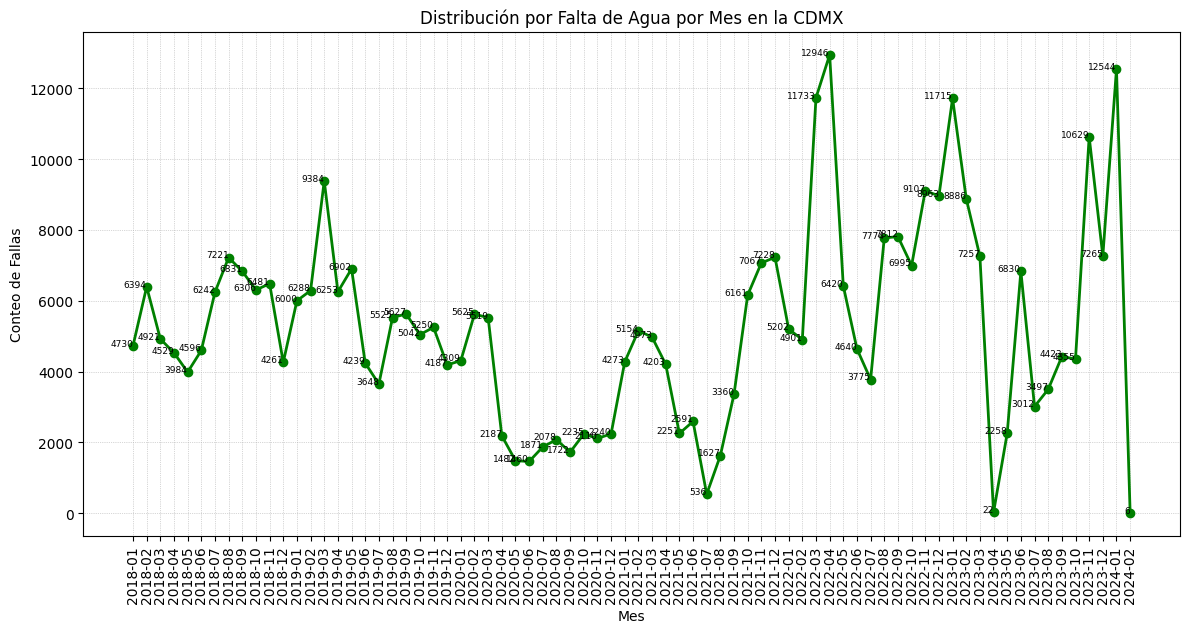

In [24]:
conteoMensual = promedioDistribucion(periodo='M')


# Crear una figura y un eje
plt.figure(figsize=(12, 6))

# Cambiar el ancho del trazo usando el parámetro 'linewidth'
plt.plot(conteoMensual['Mes'].astype(str), conteoMensual['conteo_fallas'], linewidth=2, marker='o', color='green')

#Añadir anotaciones de los valores en cada punto
for i in range(len(conteoMensual)):
    plt.text(conteoMensual['Mes'].astype(str).iloc[i], conteoMensual['conteo_fallas'].iloc[i], str(conteoMensual['conteo_fallas'].iloc[i]), fontsize=6.5, ha='right')

# Añadir título y etiquetas de ejes
plt.title('Distribución por Falta de Agua por Mes en la CDMX')
plt.xlabel('Mes')
plt.ylabel('Conteo de Fallas')
# Añadir un grid punteado
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

¿En que año hubieron mas reportes?

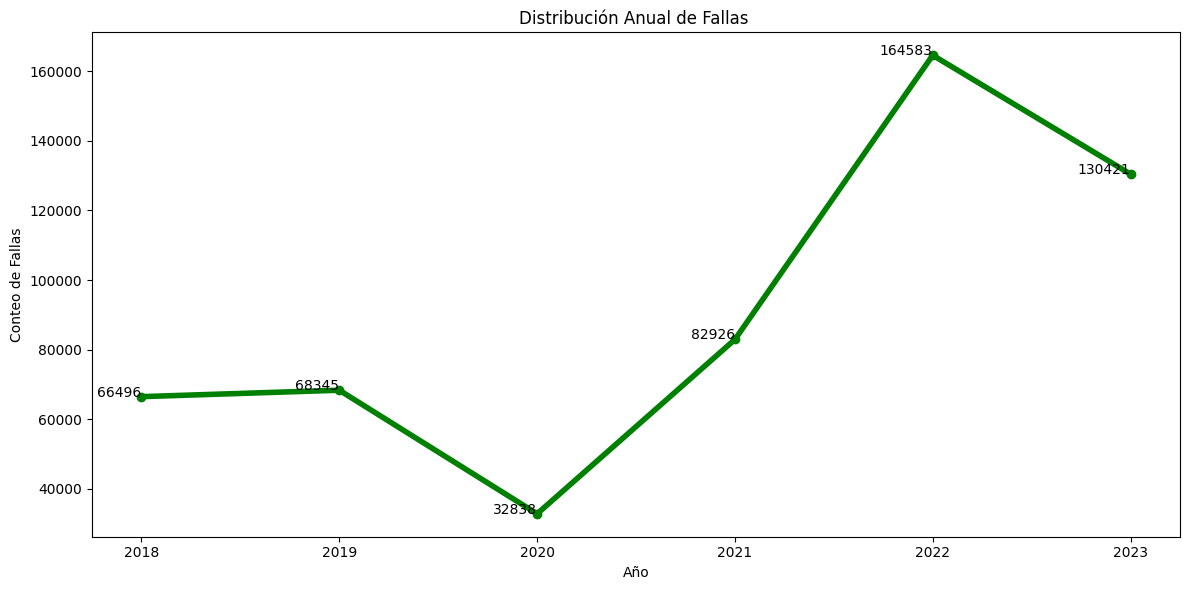

In [25]:

# Convertir la columna 'fecha' a tipo datetime
historico['fecha'] = pd.to_datetime(historico['fecha'])

# Filtrar los datos hasta el final del 2023
historico = historico[historico['fecha'] <= '2023-12-31']

# Crear una nueva columna con el año, redondeado al año
historico['año'] = historico['fecha'].dt.to_period('Y')

# Contar las fallas por año
conteoAnual = historico['año'].value_counts().sort_index()

# Convertir el conteo a un DataFrame
conteoAnual = pd.DataFrame(conteoAnual).reset_index()

# Renombrar las columnas
conteoAnual.columns = ['año', 'conteo_fallas']

# Crear una figura y un eje
plt.figure(figsize=(12, 6))

# Cambiar el ancho del trazo usando el parámetro 'linewidth'
plt.plot(conteoAnual['año'].astype(str), conteoAnual['conteo_fallas'], linewidth=4, marker='o', color='green')

# Añadir anotaciones de los valores en cada punto
for i in range(len(conteoAnual)):
    plt.text(conteoAnual['año'].astype(str).iloc[i], conteoAnual['conteo_fallas'].iloc[i], str(conteoAnual['conteo_fallas'].iloc[i]), fontsize=10, ha='right')

# Añadir título y etiquetas de ejes
plt.title('Distribución Anual de Fallas ')
plt.xlabel('Año')
plt.ylabel('Conteo de Fallas')

# Mostrar el gráfico
plt.tight_layout()
plt.show()